In [1]:
from keras import layers
from keras import Sequential
from keras import activations
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import callbacks

from gensim.models import Word2Vec
from gensim import corpora
from gensim.utils import simple_preprocess

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

/Users/chanzeebm/opt/miniconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# 加载语料
def gen_corpus(corpus):
    with corpus.open("r") as f:
        return f.read()

In [3]:
# 加载数据
file_path = Path("./aclImdb/")
def load_data(target="train", /):
    assert target.lower() in ["train", "test"], f"Target must be either 'train' or 'test', got: {target}"
    categories = ["pos", "neg"]
    target_path = file_path.joinpath(target)
    labels = np.asarray([])
    corpus = []
    for category in categories:
        label_path = target_path.joinpath(category)
        all_txt_files = label_path.glob("*.txt")
        
        plain_texts = map(gen_corpus, all_txt_files)
        temp_corpus = [simple_preprocess(plain_text) for plain_text in plain_texts]
        corpus += temp_corpus
        
        if category == 'neg':
            labels = np.insert(labels, 0, np.zeros((len(temp_corpus), )))
        else :
            labels = np.insert(labels, 0, np.ones((len(temp_corpus), )))
    return corpus, labels

In [4]:
corpus, labels = load_data()

In [5]:
# 初始化最大词汇量、每个句子最大长度、每个词对应维度
max_words = 15000
max_len = 150
vocab_size = 64

In [6]:
# 建立tokenizer，主要用于把词语转化为向量
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(corpus)

In [7]:
x_train = tokenizer.texts_to_sequences(corpus)
x_train = pad_sequences(x_train, maxlen=max_len)

### 开发基准模型
基准模型只使用最普通的RNN处理方法，一个词嵌入层和单层LSTM，由此来训练一个适合此情感分析的Embedded。

In [8]:
# 打乱数据
indicies = np.arange(0, len(x_train))
np.random.shuffle(indicies)
x_train = x_train[indicies]
labels = labels[indicies]

In [9]:
# 基准模型开发
model = Sequential()
model.add(layers.Embedding(input_dim=max_words, output_dim=vocab_size, input_length=max_len))
model.add(layers.LSTM(32))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ht = model.fit(x_train, labels, epochs=5, validation_split=0.1, batch_size=64, shuffle=True)

Epoch 1/5
352/352 [==============================] - 18s 46ms/step - loss: 0.5676 - accuracy: 0.6860 - val_loss: 0.2958 - val_accuracy: 0.8852
Epoch 2/5
352/352 [==============================] - 14s 41ms/step - loss: 0.2384 - accuracy: 0.9142 - val_loss: 0.2853 - val_accuracy: 0.8832
Epoch 3/5
352/352 [==============================] - 14s 38ms/step - loss: 0.1564 - accuracy: 0.9460 - val_loss: 0.3026 - val_accuracy: 0.8772
Epoch 4/5
352/352 [==============================] - 13s 37ms/step - loss: 0.1152 - accuracy: 0.9646 - val_loss: 0.3782 - val_accuracy: 0.8656
Epoch 5/5
352/352 [==============================] - 13s 37ms/step - loss: 0.0843 - accuracy: 0.9725 - val_loss: 0.4370 - val_accuracy: 0.8528


In [10]:
hd = ht.history
accuracy = hd["accuracy"]
val_accuracy = hd["val_accuracy"]

loss = hd["loss"]
val_loss = hd["val_loss"]

epochs = range(0, 5)

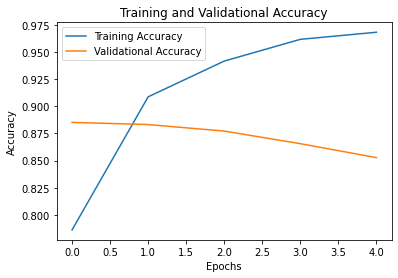

In [11]:
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Accuracy")
plt.title("Training and Validational Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

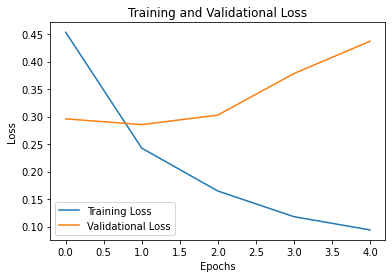

In [12]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Training and Validational Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 模型解析
模型在第一轮以后开始过拟合，并且训练速度较慢。

In [13]:
# 利用skip-gram模型生成word2vec词向量。
word2vec_model = Word2Vec(corpus, sg=1, vector_size=vocab_size)

In [14]:
# 初始化embedding层的权重
embedd_matrix = np.zeros((max_words, vocab_size))

In [15]:
# 把训练好的word2vec向量加载到embedding matrix里。
word_index = tokenizer.word_index
default_values = np.zeros((vocab_size, ))
wv = word2vec_model.wv
for word, index in word_index.items():
    if index < max_words:
        if word in wv.index_to_key:
            embedd_matrix[index] = wv[word]
        else :
            embedd_matrix[index] = default_values

In [16]:
# 新建keras词向量层，使用word2vec的词向量且不可训练
embedding_layer = layers.Embedding(input_dim=max_words, output_dim=vocab_size, input_length=max_len, weights=[embedd_matrix], trainable=False)

In [17]:
# 使用word2vec的基本模型，与基准模型的不同就只有使用的是word2vec的词向量。
model = Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(32))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [18]:
word2vec_ht = model.fit(x_train, labels, epochs=5, validation_split=0.1, batch_size=64)

Epoch 1/5
352/352 [==============================] - 12s 30ms/step - loss: 0.6260 - accuracy: 0.6423 - val_loss: 0.4466 - val_accuracy: 0.7944
Epoch 2/5
352/352 [==============================] - 10s 28ms/step - loss: 0.4735 - accuracy: 0.7812 - val_loss: 0.4105 - val_accuracy: 0.8172
Epoch 3/5
352/352 [==============================] - 10s 29ms/step - loss: 0.4396 - accuracy: 0.7970 - val_loss: 0.3864 - val_accuracy: 0.8376
Epoch 4/5
352/352 [==============================] - 11s 30ms/step - loss: 0.4120 - accuracy: 0.8176 - val_loss: 0.3698 - val_accuracy: 0.8304
Epoch 5/5
352/352 [==============================] - 10s 29ms/step - loss: 0.3996 - accuracy: 0.8183 - val_loss: 0.3593 - val_accuracy: 0.8380


In [19]:
word2vec_hd = word2vec_ht.history
accuracy = word2vec_hd["accuracy"]
val_accuracy = word2vec_hd["val_accuracy"]

loss = word2vec_hd["loss"]
val_loss = word2vec_hd["val_loss"]

epochs = range(1, len(loss) + 1)

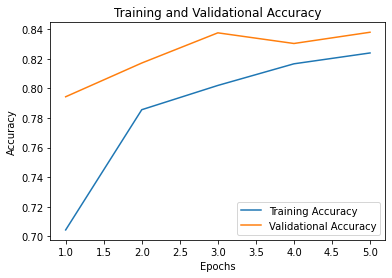

In [20]:
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Accuracy")
plt.title("Training and Validational Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

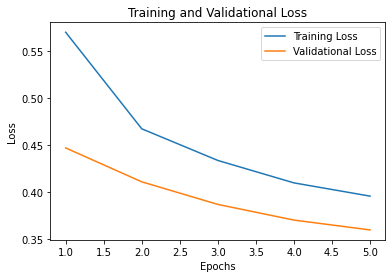

In [21]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Training and Validational Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 模型解析
可以看到模型的其他参数不变，使用了word2vec预处理以后模型得到了极大的升华，而且不用训练embedded速度极快，并且具有极大提升空间，说明word2vec对NLP具有重要作用。

## 优化pre-trained by word2vec模型

- 首先使用更大的LSTM和加入更大的Full Connection Network来训练模型

In [22]:
# 新建模型，使用Word2Vec的作为词嵌入，而且不训练该层。
model = Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.LSTM(64))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(128))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(256))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [23]:
ht = model.fit(x_train, labels, epochs=40, batch_size=64, validation_split=0.1)

Epoch 1/40
352/352 [==============================] - 29s 77ms/step - loss: 0.5821 - accuracy: 0.6747 - val_loss: 0.4120 - val_accuracy: 0.8136
Epoch 2/40
352/352 [==============================] - 27s 75ms/step - loss: 0.4395 - accuracy: 0.7987 - val_loss: 0.3989 - val_accuracy: 0.8068
Epoch 3/40
352/352 [==============================] - 27s 76ms/step - loss: 0.4141 - accuracy: 0.8137 - val_loss: 0.3671 - val_accuracy: 0.8492
Epoch 4/40
352/352 [==============================] - 26s 75ms/step - loss: 0.3908 - accuracy: 0.8314 - val_loss: 0.3331 - val_accuracy: 0.8548
Epoch 5/40
352/352 [==============================] - 27s 78ms/step - loss: 0.3645 - accuracy: 0.8405 - val_loss: 0.3880 - val_accuracy: 0.8488
Epoch 6/40
352/352 [==============================] - 28s 80ms/step - loss: 0.3547 - accuracy: 0.8530 - val_loss: 0.3049 - val_accuracy: 0.8712
Epoch 7/40
352/352 [==============================] - 27s 78ms/step - loss: 0.3228 - accuracy: 0.8651 - val_loss: 0.3188 - val_accuracy:

In [24]:
word2vec_hd = ht.history
accuracy = word2vec_hd["accuracy"]
val_accuracy = word2vec_hd["val_accuracy"]

loss = word2vec_hd["loss"]
val_loss = word2vec_hd["val_loss"]

epochs = range(1, len(loss) + 1)

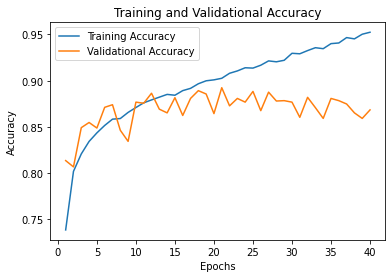

In [25]:
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Accuracy")
plt.title("Training and Validational Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

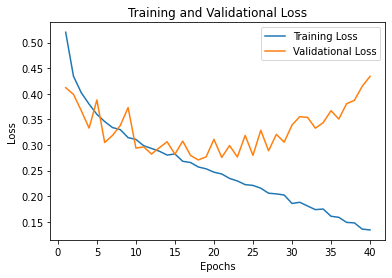

In [26]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Training and Validational Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 模型解析
在参数量如此庞大的模型中，使用了word2vec预训练的模型也在第20轮开始过拟合，但也比基准模型强很多倍。

### 解决过拟合
#### 过拟合的产生
- 数据差异性较大，本来第i个样本与目标相关性不高，但偏偏选取了强相关的样本训练，此项可排除。
- 参数过多，待定。
- 训练过程中存在大量噪音，此项可排除。
- 网络容量过大。
- 权重系数无惩罚项。
- 数据量不足。

#### 解决方法
- 添加dropout。
- 减少网络容量。
- 添加L2惩罚。
- ~~增加数据量。~~

In [27]:
import random
random_indicies = random.sample(range(0, len(x_train)), int(len(x_train) * 0.1))

In [28]:
part_x_train = x_train[random_indicies]
part_y_labels = labels[random_indicies]

In [29]:
class OptimizerChanger(callbacks.EarlyStopping):
    
    def __init__(self, x_train, y_train, **kwargs):
        super(OptimizerChanger, self).__init__(**kwargs)
        self.x_train = x_train
        self.y_train = y_train
        
        
    def on_train_end(self, logs=None):
        self.model.compile(optimizer="SGD", loss="binary_crossentropy", metrics=["accuracy"])
        self.model.fit(self.x_train, self.y_train, epochs=10, batch_size=128, validation_split=0.1, shuffle=True)
        
        

In [30]:
from keras.optimizers import Adam

# 适用于sigmoid等普通函数的权重初始化
from keras.initializers import glorot_normal
# 适用于Relu激活函数的高斯分布初始化
from keras.initializers import he_normal
# 使用刚刚的模型，添加dropout等方法解决过拟合
model = Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(32, return_sequences=True, recurrent_dropout=0.5, kernel_regularizer="l2"))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dropout(rate=0.3))

model.add(layers.LSTM(64, recurrent_dropout=0.5, kernel_regularizer="l2"))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(64, kernel_initializer=he_normal()))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(128, kernel_initializer=he_normal()))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(256, kernel_initializer=he_normal()))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.Dropout(rate=0.3))

model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=glorot_normal()))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
cbs = [
    callbacks.ModelCheckpoint("./word2vec_best_model_d.h5", save_best_only=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, cooldown=10, min_lr=5e-4),
    callbacks.EarlyStopping(patience=20, restore_best_weights=True)
]
ht = model.fit(x_train, labels, epochs=150, batch_size=128, validation_split=0.1, callbacks=cbs, shuffle=True)


Epoch 1/150
176/176 [==============================] - 35s 182ms/step - loss: 1.4363 - accuracy: 0.5729 - val_loss: 0.6379 - val_accuracy: 0.7552
Epoch 2/150
176/176 [==============================] - 30s 172ms/step - loss: 0.6231 - accuracy: 0.7498 - val_loss: 0.4939 - val_accuracy: 0.8088
Epoch 3/150
176/176 [==============================] - 31s 176ms/step - loss: 0.5298 - accuracy: 0.7944 - val_loss: 0.4814 - val_accuracy: 0.8096
Epoch 4/150
176/176 [==============================] - 31s 174ms/step - loss: 0.5071 - accuracy: 0.8027 - val_loss: 0.4557 - val_accuracy: 0.8236
Epoch 5/150
176/176 [==============================] - 31s 177ms/step - loss: 0.4829 - accuracy: 0.8132 - val_loss: 0.5009 - val_accuracy: 0.8312
Epoch 6/150
176/176 [==============================] - 30s 173ms/step - loss: 0.4992 - accuracy: 0.7978 - val_loss: 0.4518 - val_accuracy: 0.8204
Epoch 7/150
176/176 [==============================] - 31s 173ms/step - loss: 0.4705 - accuracy: 0.8127 - val_loss: 0.4052 -

Epoch 56/150
176/176 [==============================] - 35s 197ms/step - loss: 0.3555 - accuracy: 0.8644 - val_loss: 0.3375 - val_accuracy: 0.8792
Epoch 57/150
176/176 [==============================] - 35s 199ms/step - loss: 0.3548 - accuracy: 0.8659 - val_loss: 0.3396 - val_accuracy: 0.8724
Epoch 58/150
176/176 [==============================] - 35s 198ms/step - loss: 0.3534 - accuracy: 0.8646 - val_loss: 0.3239 - val_accuracy: 0.8836

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0005.
Epoch 59/150
176/176 [==============================] - 35s 200ms/step - loss: 0.3607 - accuracy: 0.8628 - val_loss: 0.3494 - val_accuracy: 0.8544
Epoch 60/150
176/176 [==============================] - 36s 202ms/step - loss: 0.3613 - accuracy: 0.8652 - val_loss: 0.3222 - val_accuracy: 0.8836
Epoch 61/150
176/176 [==============================] - 35s 199ms/step - loss: 0.3471 - accuracy: 0.8669 - val_loss: 0.3304 - val_accuracy: 0.8792
Epoch 62/150
176/176 [==============================

In [32]:
word2vec_hd = ht.history
accuracy = word2vec_hd["accuracy"]
val_accuracy = word2vec_hd["val_accuracy"]

loss = word2vec_hd["loss"]
val_loss = word2vec_hd["val_loss"]

epochs = range(1, len(loss) + 1)

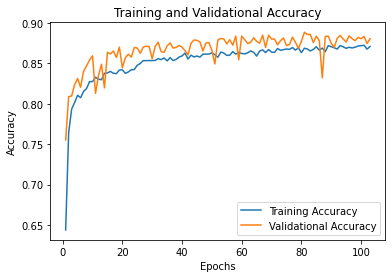

In [33]:
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Accuracy")
plt.title("Training and Validational Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

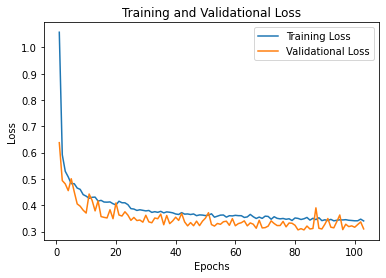

In [34]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Training and Validational Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 训练过程记录
1. LSTM: (32, 64), kernel_regularizer=l2, dropout=0.3<br>
   Dense: (64, 128, 256), dropout=0.3 <br>
   Epochs: 20<br>
   结果: 没有过拟合, 但没有完全收敛成功，添加了规则以后需要适当增加训练轮次。\
   
2. LSTM: (32, 64), kernel_regularizer=l2, dropout=0.3<br>
   Dense: (64, 128, 256), dropout=0.3 <br>
   Epochs: **40**<br>
   结果: 最终于35轮以后开始过拟合，对比没有使用规则的模型，取得了很大进步。
   
3. LSTM: (32, 64), kernel_regularizer=l2, dropout=0.3, **recurrent_dropout=0.5**<br>
   Dense: (64, 128, 256), dropout=0.3 <br>
   Epochs: **100**<br>
   结果: 最终结果于67轮以后开始过拟合，验证精度不再上升，最终测试精度在86%。
   
4. LSTM: (32, 64), kernel_regularizer=l2, dropout=0.3, **recurrent_dropout=0.5**<br>
   Dense: (64, 128, 256), dropout=0.3 <br>
   Epochs: **150**<br>
   结果：模型没有过拟合，并且使用提前停止和保存最优方案。

In [35]:
from keras.models import load_model

In [36]:
text_corpus, y_test = load_data("test")

In [37]:
x_test = tokenizer.texts_to_sequences(text_corpus)

In [38]:
x_test = pad_sequences(x_test, maxlen=max_len)

In [39]:
test_indicies = np.arange(0, len(x_test))
np.random.shuffle(test_indicies)
x_test, y_test = x_test[test_indicies], y_test[test_indicies]

In [40]:
model = load_model("./word2vec_best_model.h5")

In [41]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 23s 29ms/step - loss: 0.2957 - accuracy: 0.8863


[0.29574859142303467, 0.8862800002098083]

### 1D CNN for NLP

卷积网络的本质是空间识别，它具有平移不变性，在某个空间学习到的模式可以在其他空间识别出来；<br>
加上池化层的降维，可以防止过拟合；<br>
网络越往后拥有的表达能力越强，前面学习的是局部模式，由局部组成后面的抽象表示。

In [42]:
# 训练一维cnn网络来解决同样的问题
cnn_model = Sequential()
cnn_model.add(embedding_layer)

# 由128个长度为7的一维卷积核与词向量作卷积，输出128个特征图，每个特征图的尺寸为150-7+1=144，
# 权重添加l2惩罚，避免过拟合；使用了BN层，使用不再需要bias。
cnn_model.add(layers.Conv1D(128, 7, kernel_regularizer='l2', activation='relu', use_bias=False))
# 对第一层作BN传入下一层
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Conv1D(128, 7, kernel_regularizer='l2', activation='relu', use_bias=False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPool1D(3))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Conv1D(64, 7, kernel_regularizer='l2', activation='relu', use_bias=False))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Conv1D(64, 5, kernel_regularizer='l2', activation='relu', use_bias=False))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPool1D(3))
cnn_model.add(layers.BatchNormalization())

# cnn_model.add(layers.LSTM(32, dropout=0.5, recurrent_dropout=0.5, return_sequences=True, kernel_regularizer='l2',
#                           kernel_initializer=glorot_normal(), recurrent_regularizer='l2'))
cnn_model.add(layers.LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer='l2',
                          kernel_initializer=glorot_normal(), recurrent_regularizer='l2'))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(128, activation="relu", use_bias=False))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.BatchNormalization())

cnn_model.add(layers.Dense(1, activation="sigmoid"))
cnn_model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

In [43]:
cnn_cbs = [
    callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, cooldown=3, min_lr=1e-4),
    callbacks.ModelCheckpoint("./cnn_word2vec.h5", save_best_only=True),
    callbacks.EarlyStopping(patience=15, )
]
cnn_ht = cnn_model.fit(x_train, labels, epochs=150, batch_size=128, validation_split=0.1, shuffle=True, callbacks=cnn_cbs)


Epoch 1/150
176/176 [==============================] - 31s 159ms/step - loss: 3.7355 - accuracy: 0.7285 - val_loss: 0.9544 - val_accuracy: 0.7720
Epoch 2/150
176/176 [==============================] - 33s 189ms/step - loss: 0.7374 - accuracy: 0.7857 - val_loss: 0.8667 - val_accuracy: 0.7668
Epoch 3/150
176/176 [==============================] - 31s 175ms/step - loss: 0.7602 - accuracy: 0.7994 - val_loss: 1.0965 - val_accuracy: 0.6196
Epoch 4/150
176/176 [==============================] - 32s 179ms/step - loss: 0.7122 - accuracy: 0.8120 - val_loss: 1.1056 - val_accuracy: 0.6740
Epoch 5/150
176/176 [==============================] - 32s 181ms/step - loss: 0.6401 - accuracy: 0.8176 - val_loss: 2.0017 - val_accuracy: 0.5136
Epoch 6/150
176/176 [==============================] - 32s 183ms/step - loss: 0.6170 - accuracy: 0.8233 - val_loss: 1.5641 - val_accuracy: 0.5708
Epoch 7/150
176/176 [==============================] - 32s 183ms/step - loss: 0.5989 - accuracy: 0.8150 - val_loss: 0.7526 -

176/176 [==============================] - 31s 178ms/step - loss: 0.3341 - accuracy: 0.8740 - val_loss: 0.4128 - val_accuracy: 0.8300
Epoch 56/150
176/176 [==============================] - 32s 181ms/step - loss: 0.3345 - accuracy: 0.8707 - val_loss: 0.4848 - val_accuracy: 0.7948
Epoch 57/150
176/176 [==============================] - 32s 181ms/step - loss: 0.3315 - accuracy: 0.8732 - val_loss: 0.3683 - val_accuracy: 0.8560

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 58/150
176/176 [==============================] - 31s 179ms/step - loss: 0.3246 - accuracy: 0.8742 - val_loss: 0.3442 - val_accuracy: 0.8628
Epoch 59/150
176/176 [==============================] - 32s 183ms/step - loss: 0.3196 - accuracy: 0.8740 - val_loss: 0.3486 - val_accuracy: 0.8604
Epoch 60/150
176/176 [==============================] - 31s 178ms/step - loss: 0.3119 - accuracy: 0.8773 - val_loss: 0.6071 - val_accuracy: 0.7316
Epoch 61/150
176/176 [============================

In [44]:
cnn_hd = cnn_ht.history
accuracy = cnn_hd["accuracy"]
val_accuracy = cnn_hd["val_accuracy"]

loss = cnn_hd["loss"]
val_loss = cnn_hd["val_loss"]

epochs = range(1, len(loss) + 1)

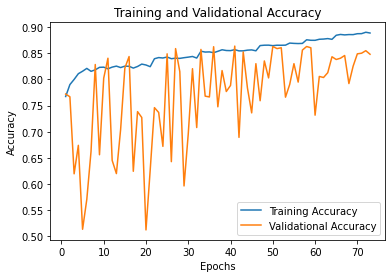

In [45]:
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validational Accuracy")
plt.title("Training and Validational Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

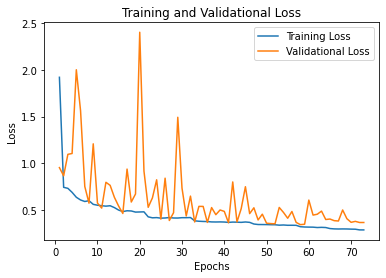

In [46]:
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validational Loss")
plt.title("Training and Validational Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [47]:
model = load_model("./cnn_word2vec.h5")
model.evaluate(x_test, y_test)

782/782 [==============================] - 10s 12ms/step - loss: 0.3573 - accuracy: 0.8524


[0.3572794198989868, 0.852400004863739]

### 结论
一维cnn一样可以对序列作预测，并且cnn是识别空间的模式，对顺序不严格的序列可以用卷积神经网络来执行，但是一旦顺序重要就不能这样做，
比如根据历史天气数据预测明天天气数据这种顺序性比较重要的回归问题。<br>
最终神经网络以85%略逊于RNN的准确率完成任务，这或许数据里面有较多「转折」之类的语句，比如先表扬后批评的，cnn不能抓住「but」这种转折，它能对一些good，bad，awesome之类的代表性词语来判断句子是正面还是负面评价。<br>

### BN层的作用
- 可以使用更大的学习率。
- BN的标准化过程会移除直流分量，不再需要bias。
- 对权重的初始化也不再敏感。
- 可以使用更深的网络。
- 具有正则化作用，但不能代替L2或Dropout